# Time Series Forecasting with FLAML Library

## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can

 - serve as an economical AutoML engine,
 - be used as a fast hyperparameter tuning tool, or
 - be embedded in self-tuning software that requires low latency & resource in repetitive tuning tasks.

In this notebook, we demonstrate how to use FLAML library for time series forecasting tasks: univariate time series forecasting (only time), multivariate time series forecasting (with exogneous variables) and forecasting discrete values.

FLAML requires Python>=3.6. To run this notebook example, please install flaml with the notebook and forecast option:


In [1]:
!pip install flaml[notebook,ts_forecast]

## 2. Forecast Problem

### Load data and preprocess

Import co2 data from statsmodel. The dataset is from “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. The task is to predict monthly CO2 samples given only timestamps.

In [2]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas().data
# data is given in weeks, but the task is to predict monthly, so use monthly averages instead
data = data['co2'].resample('MS').mean()
data = data.bfill().ffill()  # makes sure there are no missing values
data = data.to_frame().reset_index()

In [3]:
# split the data into a train dataframe and X_test and y_test dataframes, where the number of samples for test is equal to
# the number of periods the user wants to predict
num_samples = data.shape[0]
time_horizon = 12
split_idx = num_samples - time_horizon
train_df = data[:split_idx]  # train_df is a dataframe with two columns: timestamp and label
X_test = data[split_idx:]['index'].to_frame()  # X_test is a dataframe with dates for prediction
y_test = data[split_idx:]['co2']  # y_test is a series of the values corresponding to the dates for prediction

### Run FLAML

In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them.

In [4]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [5]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'mape',  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'ts_forecast',  # task type
    "log_file_name": 'CO2_forecast.log',  # flaml log file
    "eval_method": "holdout",  # validation method can be chosen from ['auto', 'holdout', 'cv']
    "seed": 7654321,  # random seed
}

In [6]:
'''The main flaml automl API'''
automl.fit(dataframe=train_df,  # training data
           label='co2',  # label column
           period=time_horizon,  # key word argument 'period' must be included for forecast task)
           **settings)

[flaml.automl: 02-28 21:28:18] {2060} INFO - task = ts_forecast
[flaml.automl: 02-28 21:28:18] {2062} INFO - Data split method: time
[flaml.automl: 02-28 21:28:18] {2066} INFO - Evaluation method: holdout
[flaml.automl: 02-28 21:28:18] {2147} INFO - Minimizing error metric: mape
[flaml.automl: 02-28 21:28:18] {2205} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
[flaml.automl: 02-28 21:28:18] {2458} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-28 21:28:19] {2573} INFO - Estimated sufficient time budget=2854s. Estimated necessary time budget=3s.
[flaml.automl: 02-28 21:28:19] {2620} INFO -  at 1.0s,	estimator lgbm's best error=0.0621,	best estimator lgbm's best error=0.0621
[flaml.automl: 02-28 21:28:19] {2458} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-28 21:28:19] {2620} INFO -  at 1.0s,	estimator lgbm's best error=0.0621,	best estimator lgbm's best error=0.0621
[flaml.aut

### Best model and metric

In [7]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print(f'Best mape on validation data: {automl.best_loss}')
print(f'Training duration of best run: {automl.best_config_train_time}s')

Best ML leaner: sarimax
Best hyperparmeter config: {'p': 8.0, 'd': 0.0, 'q': 8.0, 'P': 6.0, 'D': 3.0, 'Q': 1.0, 's': 6}
Best mape on validation data: 0.00043466573064228554
Training duration of best run: 0.6672513484954834s


In [8]:
automl.model.estimator

In [9]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [10]:
''' compute predictions of testing dataset '''
flaml_y_pred = automl.predict(X_test)
print(f"Predicted labels\n{flaml_y_pred}")
print(f"True labels\n{y_test}")

Predicted labels
2001-01-01    370.568362
2001-02-01    371.297747
2001-03-01    372.087653
2001-04-01    373.040897
2001-05-01    373.638221
2001-06-01    373.202665
2001-07-01    371.621574
2001-08-01    369.611740
2001-09-01    368.307775
2001-10-01    368.360786
2001-11-01    369.476460
2001-12-01    370.849193
Freq: MS, Name: predicted_mean, dtype: float64
True labels
514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


In [11]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_true=y_test, y_predict=flaml_y_pred))

mape = 0.0005710586398294955


### Log history

In [12]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=180)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 502, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'optimize_for_horizon': False, 'lags': 3}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'optimize_for_horizon': False, 'lags': 3}}
{'Current Learner': 'lgbm', 'Current Sample': 502, 'Current Hyper-parameters': {'n_estimators': 8, 'num_leaves': 4, 'min_child_samples': 19, 'learning_rate': 0.18686130359903158, 'log_max_bin': 9, 'colsample_bytree': 0.9311834484407709, 'reg_alpha': 0.0013872402855481538, 'reg_lambda': 0.43503398494225104, 'optimize_for_horizon': False, 'lags': 1}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_esti

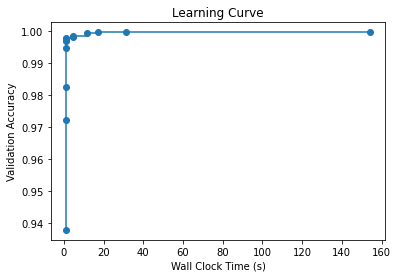

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### Visualize

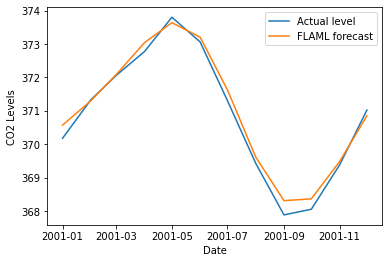

In [14]:
import matplotlib.pyplot as plt
plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()

## 3. Forecast Problems with Exogeneous Variables

### Load Data and Preprocess

Load dataset on NYC energy consumption. The task is to predict the average hourly demand of enegry used in a day given information on time, temperature, and precipitation. Temperature and precipiation values are both continuous values. To demonstrate FLAML's ability to handle categorical values as well, create a column with categorical values, where 1 denotes daily tempurature is above monthly average and 0 is below.

In [15]:
''' multivariate time series forecasting dataset'''
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)
multi_df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)
# preprocessing data
multi_df["timeStamp"] = pd.to_datetime(multi_df["timeStamp"])
multi_df = multi_df.set_index("timeStamp")
multi_df = multi_df.resample("D").mean()
multi_df["temp"] = multi_df["temp"].fillna(method="ffill")
multi_df["precip"] = multi_df["precip"].fillna(method="ffill")
multi_df = multi_df[:-2]  # last two rows are NaN for 'demand' column so remove them
multi_df = multi_df.reset_index()

In [16]:
''' Use feature engineering to create a categorical value'''
# Using temperature values create categorical values 
# where 1 denotes daily tempurature is above monthly average and 0 is below.

def get_monthly_avg(data):
    data["month"] = data["timeStamp"].dt.month
    data = data[["month", "temp"]].groupby("month")
    data = data.agg({"temp": "mean"})
    return data

monthly_avg = get_monthly_avg(multi_df).to_dict().get("temp")

def above_monthly_avg(date, temp):
    month = date.month
    if temp > monthly_avg.get(month):
        return 1
    else:
        return 0

multi_df["temp_above_monthly_avg"] = multi_df.apply(
    lambda x: above_monthly_avg(x["timeStamp"], x["temp"]), axis=1
)

del multi_df["temp"], multi_df["month"]  # remove temperature column to reduce redundancy

In [17]:
# split data into train and test
num_samples = multi_df.shape[0]
multi_time_horizon = 180
split_idx = num_samples - multi_time_horizon
multi_train_df = multi_df[:split_idx]
multi_test_df = multi_df[split_idx:]

multi_X_test = multi_test_df[
    ["timeStamp", "precip", "temp_above_monthly_avg"]
]  # test dataframe must contain values for the regressors / multivariate variables
multi_y_test = multi_test_df["demand"]

### Run FLAML

In [18]:
automl = AutoML()
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": "mape",  # primary metric
    "task": "ts_forecast",  # task type
    "log_file_name": "energy_forecast_categorical.log",  # flaml log file
    "eval_method": "holdout",
    "log_type": "all",
    "label": "demand",
}
'''The main flaml automl API'''
try:
    import prophet

    automl.fit(dataframe=multi_train_df, **settings, period=multi_time_horizon)
except ImportError:
    print("not using prophet due to ImportError")
    automl.fit(
        dataframe=multi_train_df,
        **settings,
        estimator_list=["arima", "sarimax"],
        period=multi_time_horizon,
    )

[flaml.automl: 02-28 21:32:20] {2060} INFO - task = ts_forecast
[flaml.automl: 02-28 21:32:20] {2062} INFO - Data split method: time
[flaml.automl: 02-28 21:32:20] {2066} INFO - Evaluation method: holdout
[flaml.automl: 02-28 21:32:20] {2147} INFO - Minimizing error metric: mape
[flaml.automl: 02-28 21:32:20] {2205} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
[flaml.automl: 02-28 21:32:20] {2458} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-28 21:32:20] {2573} INFO - Estimated sufficient time budget=269s. Estimated necessary time budget=0s.
[flaml.automl: 02-28 21:32:20] {2620} INFO -  at 0.1s,	estimator lgbm's best error=0.1103,	best estimator lgbm's best error=0.1103
[flaml.automl: 02-28 21:32:20] {2458} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-28 21:32:20] {2620} INFO -  at 0.1s,	estimator lgbm's best error=0.1103,	best estimator lgbm's best error=0.1103
[flaml.auto

2016-08-16 00:00:00 2017-02-11 00:00:00 (180, 2)


[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.0s,	estimator sarimax's best error=0.6434,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 10, current learner lgbm
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.0s,	estimator lgbm's best error=0.0983,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 11, current learner xgboost
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.0s,	estimator xgboost's best error=0.6523,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 12, current learner rf
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.1s,	estimator rf's best error=0.0862,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 13, current learner xgboost
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.1s,	estimator xgboost's best error=0.2637,	best estimator prophet's best error=0.0592

2016-08-16 00:00:00 2017-02-11 00:00:00 (180, 2)


[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 15, current learner xgboost
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.2s,	estimator xgboost's best error=0.0959,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 16, current learner extra_tree
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.2s,	estimator extra_tree's best error=0.0961,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 17, current learner extra_tree
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.2s,	estimator extra_tree's best error=0.0961,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 18, current learner xgboost
[flaml.automl: 02-28 21:32:26] {2620} INFO -  at 6.2s,	estimator xgboost's best error=0.0959,	best estimator prophet's best error=0.0592
[flaml.automl: 02-28 21:32:26] {2458} INFO - iteration 19, current learner xgb_limitdepth
[flaml.automl: 02-

2016-08-16 00:00:00 2017-02-11 00:00:00 (180, 2)


[flaml.automl: 02-28 21:32:30] {2620} INFO -  at 10.3s,	estimator arima's best error=0.5998,	best estimator prophet's best error=0.0592


2016-08-16 00:00:00 2017-02-11 00:00:00 (180, 2)


[flaml.automl: 02-28 21:32:32] {2850} INFO - retrain prophet for 2.2s
[flaml.automl: 02-28 21:32:32] {2857} INFO - retrained model: <prophet.forecaster.Prophet object at 0x000001B1D3EE2B80>
[flaml.automl: 02-28 21:32:32] {2234} INFO - fit succeeded
[flaml.automl: 02-28 21:32:32] {2235} INFO - Time taken to find the best model: 4.351356506347656


### Prediction and Metrics

In [19]:
''' compute predictions of testing dataset '''
multi_y_pred = automl.predict(multi_X_test)
print("Predicted labels", multi_y_pred)
print("True labels", multi_y_test)

Predicted labels 0      5352.985670
1      6013.062371
2      6106.856497
3      6368.692993
4      6081.394081
          ...     
175    6841.950842
176    7584.557653
177    7614.970448
178    7729.474679
179    7585.110004
Name: yhat, Length: 180, dtype: float64
True labels 1869    5486.409375
1870    6015.156208
1871    5972.218042
1872    5838.364167
1873    5961.476375
           ...     
2044    5702.361542
2045    6398.154167
2046    6471.626042
2047    6811.112167
2048    5582.297000
Name: demand, Length: 180, dtype: float64


In [20]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_true=multi_y_test, y_predict=multi_y_pred))

mape = 0.08347031511602677


### Visualize

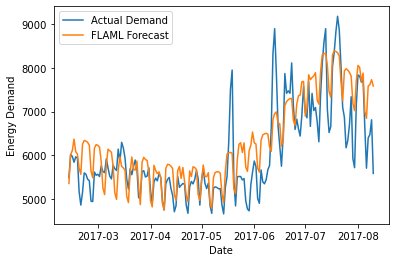

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(multi_X_test["timeStamp"], multi_y_test, label="Actual Demand")
plt.plot(multi_X_test["timeStamp"], multi_y_pred, label="FLAML Forecast")
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.legend()
plt.show()

## 4. Forecasting Discrete Values

### Load Dataset and Preprocess

Import [sales data](https://hcrystalball.readthedocs.io/en/v0.1.7/api/hcrystalball.utils.get_sales_data.html) from hcrystalball. The task is to predict whether daily sales will be above mean sales for thirty days into the future.

In [50]:
from hcrystalball.utils import get_sales_data
time_horizon = 30
df = get_sales_data(n_dates=180, n_assortments=1, n_states=1, n_stores=1)
df = df[["Sales", "Open", "Promo", "Promo2"]]
# feature engineering - create a discrete value column
# 1 denotes above mean and 0 denotes below mean
import numpy as np
df["above_mean_sales"] = np.where(df["Sales"] > df["Sales"].mean(), 1, 0)
df.reset_index(inplace=True)
# train-test split
discrete_train_df = df[:-time_horizon]
discrete_test_df = df[-time_horizon:]
discrete_X_train, discrete_X_test = (
    discrete_train_df[["Date", "Open", "Promo", "Promo2"]],
    discrete_test_df[["Date", "Open", "Promo", "Promo2"]],
)
discrete_y_train, discrete_y_test = discrete_train_df["above_mean_sales"], discrete_test_df["above_mean_sales"]

### Run FLAML

In [51]:
from flaml import AutoML
automl = AutoML()

In [52]:
settings = {
    "time_budget": 15,  # total running time in seconds
    "metric": "accuracy",  # primary metric
    "task": "ts_forecast_classification",  # task type
    "log_file_name": "sales_classification_forecast.log",  # flaml log file
    "eval_method": "holdout",
}

In [53]:
"""The main flaml automl API"""
automl.fit(X_train=discrete_X_train,
           y_train=discrete_y_train,
           **settings,
           period=time_horizon)

[flaml.automl: 02-28 21:54:50] {2060} INFO - task = ts_forecast_classification
[flaml.automl: 02-28 21:54:50] {2062} INFO - Data split method: time
[flaml.automl: 02-28 21:54:50] {2066} INFO - Evaluation method: holdout
[flaml.automl: 02-28 21:54:50] {2147} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-28 21:54:50] {2205} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 02-28 21:54:50] {2458} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-28 21:54:50] {2573} INFO - Estimated sufficient time budget=249s. Estimated necessary time budget=0s.
[flaml.automl: 02-28 21:54:50] {2620} INFO -  at 0.0s,	estimator lgbm's best error=0.2667,	best estimator lgbm's best error=0.2667
[flaml.automl: 02-28 21:54:50] {2458} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-28 21:54:50] {2620} INFO -  at 0.1s,	estimator lgbm's best error=0.2667,	best estimator lgbm's best error=0.2667
[flaml.automl: 02-28 

### Best Model and Metric

In [54]:
""" retrieve best config and best learner"""
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print(f"Best mape on validation data: {automl.best_loss}")
print(f"Training duration of best run: {automl.best_config_train_time}s")
print(automl.model.estimator)

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 6, 'max_leaves': 8, 'optimize_for_horizon': False, 'max_features': 0.1, 'lags': 8}
Best mape on validation data: 0.0
Training duration of best run: 0.022936344146728516s
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=0.1,
                     max_leaf_nodes=8, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=6, n_jobs=-1, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)


In [55]:
""" compute predictions of testing dataset """
discrete_y_pred = automl.predict(discrete_X_test)
print("Predicted label", discrete_y_pred)
print("True label", discrete_y_test)

Predicted label [1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1]
True label 150    1
151    1
152    0
153    0
154    1
155    1
156    1
157    1
158    1
159    0
160    0
161    1
162    1
163    1
164    1
165    1
166    0
167    0
168    1
169    1
170    1
171    1
172    1
173    0
174    0
175    1
176    1
177    1
178    1
179    1
Name: above_mean_sales, dtype: int32


In [56]:
from flaml.ml import sklearn_metric_loss_score
print("accuracy", "=", 1 - sklearn_metric_loss_score("accuracy", discrete_y_test, discrete_y_pred))

accuracy = 1.0


## 5. Comparison with Alternatives (CO2 Dataset)

FLAML's MAPE

In [29]:
from flaml.ml import sklearn_metric_loss_score
print('flaml mape', '=', sklearn_metric_loss_score('mape', flaml_y_pred, y_test))

flaml mape = 0.0005710586398294955


### Default Prophet

In [30]:
from prophet import Prophet
prophet_model = Prophet()

In [31]:
X_train_prophet = train_df.copy()
X_train_prophet = X_train_prophet.rename(columns={'index': 'ds', 'co2': 'y'})
prophet_model.fit(X_train_prophet)

In [32]:
X_test_prophet = X_test.copy()
X_test_prophet = X_test_prophet.rename(columns={'index': 'ds'})
prophet_y_pred = prophet_model.predict(X_test_prophet)['yhat']
print('Predicted labels', prophet_y_pred)
print('True labels', y_test)

Predicted labels 0     370.450675
1     371.177764
2     372.229577
3     373.419835
4     373.914917
5     373.406484
6     372.053428
7     370.149037
8     368.566631
9     368.646853
10    369.863891
11    371.135959
Name: yhat, dtype: float64
True labels 514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


Default Prophet MAPE

In [33]:
from flaml.ml import sklearn_metric_loss_score
print('default prophet mape', '=', sklearn_metric_loss_score('mape', prophet_y_pred, y_test))

default prophet mape = 0.0011396920680673015


### Auto ARIMA Models

In [34]:
from pmdarima.arima import auto_arima
import pandas as pd
import time

X_train_arima = train_df.copy()
X_train_arima.index = pd.to_datetime(X_train_arima['index'])
X_train_arima = X_train_arima.drop('index', axis=1)
X_train_arima = X_train_arima.rename(columns={'co2': 'y'})

In [35]:
# use same search space as FLAML
start_time = time.time()
arima_model = auto_arima(X_train_arima,
                            start_p=2, d=None, start_q=1, max_p=10, max_d=10, max_q=10,
                            suppress_warnings=True, stepwise=False, seasonal=False,
                            error_action='ignore', trace=True, n_fits=650)
autoarima_y_pred = arima_model.predict(n_periods=12)
arima_time = time.time() - start_time

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1638.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1344.207, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1222.286, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1174.928, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1188.947, Time=0.38 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1091.452, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1298.693, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1240.963, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1196.535, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1176.484, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1180.404, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.719, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=988.094, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1140.469, Time=0.57 sec
 ARIMA(3,1,0)(0,0

In [36]:
start_time = time.time()
sarima_model = auto_arima(X_train_arima,
                            start_p=2, d=None, start_q=1, max_p=10, max_d=10, max_q=10,
                            start_P=2, D=None, start_Q=1, max_P=10, max_D=10, max_Q=10, m=12,
                            suppress_warnings=True, stepwise=False, seasonal=True,
                            error_action='ignore', trace=True, n_fits=50)
sarima_time = time.time() - start_time
autosarima_y_pred = sarima_model.predict(n_periods=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.009, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1238.943, Time=0.21 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1040.890, Time=0.57 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=911.545, Time=1.81 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=823.103, Time=3.23 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=792.850, Time=6.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=447.738, Time=6.32 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=inf, Time=11.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=427.344, Time=8.22 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept

Auto ARIMA Models MAPE

In [37]:
from flaml.ml import sklearn_metric_loss_score
print('auto arima mape', '=', sklearn_metric_loss_score('mape', y_test, autoarima_y_pred))
print('auto sarima mape', '=', sklearn_metric_loss_score('mape', y_test, autosarima_y_pred))

auto arima mape = 0.0032060283828607705
auto sarima mape = 0.0007319806481537022


### Compare All

In [38]:
from flaml.ml import sklearn_metric_loss_score
print('flaml mape', '=', sklearn_metric_loss_score('mape', y_test, flaml_y_pred))
print('default prophet mape', '=', sklearn_metric_loss_score('mape', prophet_y_pred, y_test))
print('auto arima mape', '=', sklearn_metric_loss_score('mape', y_test, autoarima_y_pred))
print('auto sarima mape', '=', sklearn_metric_loss_score('mape', y_test, autosarima_y_pred))

flaml mape = 0.0005706814258795216
default prophet mape = 0.0011396920680673015
auto arima mape = 0.0032060283828607705
auto sarima mape = 0.0007319806481537022


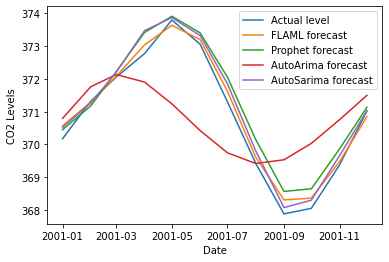

In [39]:
import matplotlib.pyplot as plt

plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.plot(X_test, prophet_y_pred, label='Prophet forecast')
plt.plot(X_test, autoarima_y_pred, label='AutoArima forecast')
plt.plot(X_test, autosarima_y_pred, label='AutoSarima forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()